# ◆Kickstarter Projects
### 目的：クラウドファンディングが成功するかを事前に予測する
### 目的変数をstateとする二値分類問題としてロジスティック回帰アルゴリズムを使ったモデルを構築する
- kaggle URL:https://www.kaggle.com/kemical/kickstarter-projects
- Create Date：2020/01/05　Author：M.Hasegawa
### ────────────────────────────────────────────────────────────────

### 【手順】

### 0.Notebook内で利用する関数の定義

### 1.データ読込
- 欠損項目を確認する

### 2.データ前処理
- 予測時に利用できない項目は、除外する。
- 目的変数を説明するのに有効そうな説明変数を見つける。
- 目的変数と説明変数の関係を確認するためのグラフを作成する。
- 質的変数が扱えない場合は、ダミー変数に置き換える。

### 3.モデル構築
- ロジスティック回帰モデルを利用する
- モデルパラメータ（重み）：$\mathbf{w} = (w_0, w_1, w_2, \dots, w_p)^{\mathrm{T}} $
- モデルへの入力：$\mathbf{x} = (1, x_1, x_2, \dots, x_p)^{\mathrm{T}} $
- 以上の2つが与えられたときのモデルの出力（確率値）：$\hat{Y}(\mathbf{x}; \mathbf{w}) =  f(\mathbf{w}^{\mathrm{T}} \mathbf{x})$
- $f$はシグモイド関数：$f(x) = \frac{1}{1 + \exp(-x)}$
- 交差検証またはホールドアウト法を用いて、汎化性能を確認しているか
- 過学習への対処は適切か
- 正規化、標準化、無相関化、白色化を取り入れているか
- ハイパーパラメータの探索を行っているか

### 4.モデル評価
- 混同行列を作成し、Accuracy、Recall、Precisionを求める

### ※データセット
- 「ks-projects-201801.csv」（データ数：378,661行15列）

| 列 | 項目 | 項目名 | 欠損有無 | 利用概要 |
|:---:|:---:|:---:|:---:|:---:|
|  1 | ID| 識別ID | - | 不要と思われる為除外 |
|  2 | name |名称 | 欠損あり | ○※文字数を算出して利用 |
|  3 | category |カテゴリ | - | ○ |
|  4 | main_category |主なカテゴリ | - | ○ |
|  5 | currency |使用通貨 | - | ○ |
|  6 | deadline |締切日 | - | ○※期間算出 |
|  7 | goal |目標調達資金額 | - | ×※usd_goal_realを使うため除外 |
|  8 | launched |開始日時 | - | ○※期間算出,月,日,時間を抽出 |
|  9 | pledged |集まった資金 | - | 予測できないため除外 |
| 10 | state |プロジェクトの状態 | - | ◎※目的変数で利用（成功と失敗のみ抽出） |
| 11 | backers |支援者数 | - | 予測できないため除外 |
| 12 | country|国 | - | ○ |
| 13 | usd_pledged |集まった資金（米ドル） | 欠損あり | 予測できないため除外 |
| 14 | usd_pledged_real |集まった資金（米ドル） | - | 予測できないため除外 |
| 15 | usd_goal_real |目標金額（米ドル） | - | ○ |

## 0.Notebook内で利用する関数の定義

In [1]:
%matplotlib inline
import pandas  as pd
import numpy   as np
import seaborn as sns
import category_encoders as ce
import matplotlib.pyplot as plt
from time import time
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.linear_model    import SGDClassifier
from sklearn.svm             import SVC
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix,precision_recall_fscore_support
from sklearn.model_selection import train_test_split # ホールドアウト法
from sklearn.preprocessing import StandardScaler # 標準化

start_notebook = time()

# ****************************************************************************
# 設定値
# ****************************************************************************

# 件数絞込用（時間がかかりすぎるため）
csv_num1 = 100000 # ※1以上の場合有効
clf_num2 = 5000 # ※1以上の場合有効

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 30)

# ============================================================================
# 関数：成功と失敗別のヒストグラムと歪度
# 引数：データ名,グラフの横幅、縦幅、刻み数（棒の数）
# ============================================================================
def show_histogram(col_name,w,h,bins_val):
    print('\n▼ ' + str(col_name) + 'の分布 ※歪度：',df[col_name].skew())
    plt.figure(figsize=(w,h))
    sns.distplot(df[df['state']==0][col_name],kde=False,rug=False,bins=bins_val,label='failed')
    sns.distplot(df[df['state']==1][col_name],kde=False,rug=False,bins=bins_val,label='successful')
    plt.title('Histogram of ' + str(col_name) + ' (bins = ' + str(bins_val) + ')')
    plt.grid(which='major',color='gray',linestyle=':')
    plt.grid(which='minor',color='gray',linestyle=':')
    plt.legend()
    plt.show()

# ============================================================================
# 関数：対数変換した成功と失敗別のヒストグラム
# 引数：データ名,グラフの横幅、縦幅、刻み数（棒の数）
# ============================================================================
def show_histogram_log1p(col_name,w,h,bins_val):
    print('\n▼ 対数変換した' + str(col_name) + 'の分布')
    plt.figure(figsize=(w,h))
    sns.distplot(np.log1p(df[df['state']==0][col_name]),kde=False,rug=False,bins=bins_val,label='failed')
    sns.distplot(np.log1p(df[df['state']==1][col_name]),kde=False,rug=False,bins=bins_val,label='successful')
    plt.title('Histogram of ' + str(col_name) + ' (bins = ' + str(bins_val) + ')')
    plt.grid(which='major',color='gray',linestyle=':')
    plt.grid(which='minor',color='gray',linestyle=':')
    plt.xlabel(col_name)
    plt.legend()
    plt.show()
    
# ============================================================================
# 関数：成功と失敗別に散布図を表示するグラフ
# 引数：データ名,グラフの横幅、縦幅
# ============================================================================
def show_scatter_plot(col_name, w, h):
    print('\n▼ ' + str(col_name) + 'の散布図')
    plt.figure(figsize=(w,h))
    data1 = df.query('state == 1') # 成功
    data2 = df.query('state == 0') # 失敗
    plt.grid(which='major',color='black',linestyle=':')
    plt.grid(which='minor',color='black',linestyle=':')
    plt.plot(data1.index, data1[col_name], 'o', color='C1', label='successful')
    plt.plot(data2.index, data2[col_name], 'x', color='C0', label='failed')
    plt.legend(loc='best')
    plt.title('Scatter plot of ' + str(col_name))
    plt.grid(which='major',color='gray',linestyle=':')
    plt.grid(which='minor',color='gray',linestyle=':')
    plt.ylabel(col_name)
    plt.xlabel('row_index')
    plt.show()
    
# ============================================================================
# 関数：2項目の相関関係と成功失敗を色分けして散布図を表示するグラフ
# 引数：データ名,グラフの横幅、縦幅
# ============================================================================
def show_corr_scatter_plot(col_name1, col_name2, w, h):
    print('\n▼ ' + str(col_name1) + ' と ' + str(col_name2) + ' の相関関係 相関係数: {:.3f}'.format(
    np.corrcoef(df[col_name1].values,df[col_name2].values)[0,1]))
    plt.figure(figsize=(w,h))
    data1 = df.query('state == 1') # 成功
    data2 = df.query('state == 0') # 失敗
    plt.grid(which='major',color='black',linestyle=':')
    plt.grid(which='minor',color='black',linestyle=':')
    plt.plot(data1[col_name1], data1[col_name2], 'o', color='C1', label='successful')
    plt.plot(data2[col_name1], data2[col_name2], 'x', color='C0', label='failed')
    plt.legend(loc='best')
    plt.title('Scatter plot of ' + str(col_name1) + ' and ' + str(col_name1))
    plt.grid(which='major',color='gray',linestyle=':')
    plt.grid(which='minor',color='gray',linestyle=':')
    plt.xlabel(col_name1)
    plt.ylabel(col_name2)
    plt.show()

# ============================================================================
# 関数：成功数と失敗数別にカウント表示するグラフ
# 引数：データ名,グラフの横幅、縦幅、降順ソート有無、xラベルの回転
# ============================================================================
def show_state_count_plot(col_name, w, h, sort_flg=False, x_rot = 0):
    plt.figure(figsize=(w,h))
    if(sort_flg):
        print('\n▼ ' + str(col_name) + '別の成功数と失敗数（降順）')
        ax = sns.countplot(df[col_name],hue=df['state'],order = df[col_name].value_counts().index)
    else:
        print('\n▼ ' + str(col_name) + '別の成功数と失敗数')
        ax = sns.countplot(df[col_name],hue=df['state'])
        
    ax.set_title('Count by ' + str(col_name))
    plt.grid(which='major',color='lightgray',linestyle=':')
    plt.grid(which='minor',color='lightgray',linestyle=':')
    ax.set_xlabel(col_name)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=x_rot, ha="right") # ラベルの回転
    ax.set_ylabel('Count')
    plt.legend()
    plt.show()

# ============================================================================
# 関数：成功率を棒グラフで比較するグラフ
# 引数：データ名,グラフの横幅、縦幅、平均値、降順ソート有無、xラベルの回転
# ============================================================================
def show_successrate_barplot(col_name, w, h, baseline, sort_flg=False, x_rot = 0):
    # stateの平均値が成功率になる（成功率＝成功の件数/全体の件数）
    successrate = pd.DataFrame(df['state'].groupby(df[col_name]).mean())
    successrate.reset_index(inplace = True) # index振り直し
    if(sort_flg):
        successrate = successrate.sort_values('state', ascending=False) # 成功率の降順
        print('\n▼ ' + str(col_name) + '別の成功率（降順）※赤線：学習データの平均成功率')
    else:
        print('\n▼ ' + str(col_name) + '別の成功率 ※赤線：学習データの平均成功率')
    plt.figure(figsize=(w,h))
    ax = sns.barplot(x=col_name, y="state", data=successrate)
    ax.axhline(baseline, alpha=0.5, color='red') # 平均値
    ax.set_title('Success rate by ' + str(col_name))
    plt.grid(which='major',color='lightgray',linestyle=':')
    plt.grid(which='minor',color='lightgray',linestyle=':')
    ax.set_xlabel(col_name)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=x_rot, ha="right") # ラベルの回転
    ax.set_ylabel('Ratio')
    plt.show()

# ============================================================================
# 関数：モデルの箱ひげ図を生成
# 引数：モデル名、交差検証結果
# ============================================================================
def show_boxplot_compare_algo(names, results):
    fig = plt.figure(figsize=(6, 4)) 
    ax = fig.add_subplot(111)
    sns.boxplot(data=results)
    ax.set_xticklabels(names) 
    plt.title('Comparison between Algorithms', size = 12, color='k')
    plt.xlabel('Percentage',size = 12,color="k")
    plt.ylabel('Algorithm',size = 12,color="k")
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.show()
    
# ============================================================================
# 関数：ハイパーパラメータチューニング
# 引数：モデル、パラメータリスト、学習データX、学習データy
# ============================================================================
import warnings
warnings.filterwarnings('ignore')
def algo_grid_search(model, param_grid, X_train, y_train):
    kfold = KFold(n_splits=5, random_state=1234)
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=kfold, n_jobs=-1)
    grid_result = grid.fit(X_train, y_train)
    best_estimator = grid_result.best_estimator_
    print("BestScore: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    print('------------------------------------------------------')
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    #for mean, stdev, param in zip(means, stds, params):
    #    print("Score: %f (%f) with: %r" % (mean, stdev, param))
    #    print('------------------------------------------------------')
    return best_estimator

# ============================================================================
# テストおよびトレーニング学習曲線の簡単なプロットを生成
# モデル、タイトル、X,y
# ============================================================================
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,n_jobs=-1,train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(6,4))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Accuracy Score")
    
    # 学習曲線
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, 
                                                            train_sizes=train_sizes,
                                                           random_state=1234)
    train_scores_mean = np.mean(train_scores, axis=1) # 分割数分のスコアの平均
    train_scores_std  = np.std(train_scores, axis=1) # 分割数分のスコアの標準偏差
    test_scores_mean  = np.mean(test_scores, axis=1) # 分割数分のスコアの平均
    test_scores_std   = np.std(test_scores, axis=1) # 分割数分のスコアの標準偏差
    
    plt.grid()
    # 標準偏差の範囲を色付け（学習データ）
    plt.fill_between(train_sizes, 
                     train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, 
                     alpha=0.1,
                     color="r")
    # 標準偏差の範囲を色付け（交差検証法）
    plt.fill_between(train_sizes, 
                     test_scores_mean - test_scores_std, 
                     test_scores_mean + test_scores_std, 
                     alpha=0.1, color="g")
    # 学習データのスコアをプロット
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    # 交差検証法スコアをプロット
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    plt.show()

## 1.データ読込

In [2]:
# ****************************************************************************
# ◆ 1.データ読込
# ****************************************************************************
df= pd.read_csv('./ks-projects-201801.csv',parse_dates=['deadline', 'launched'])

print("\n▼ 先頭5行表示")
display(df.head(5))

print("\n▼ 基本統計量")
display(df.describe())

print('\n▼ 欠損データ確認')
display(pd.DataFrame(df.isnull().sum()[df.isnull().sum()>0],columns=['Missing num']))

# PCが遅すぎるのでデータ絞り込み
if csv_num1 > 0:
    df = df[0:csv_num1]


▼ 先頭5行表示


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00



▼ 基本統計量


,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,3.786610e+05,3.786610e+05,3.786610e+05,378661.000000,3.748640e+05,3.786610e+05,3.786610e+05
mean,1.074731e+09,4.908079e+04,9.682979e+03,105.617476,7.036729e+03,9.058924e+03,4.545440e+04
std,6.190862e+08,1.183391e+06,9.563601e+04,907.185035,7.863975e+04,9.097334e+04,1.152950e+06
min,5.971000e+03,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02
25%,5.382635e+08,2.000000e+03,3.000000e+01,2.000000,1.698000e+01,3.100000e+01,2.000000e+03
50%,1.075276e+09,5.200000e+03,6.200000e+02,12.000000,3.947200e+02,6.243300e+02,5.500000e+03
75%,1.610149e+09,1.600000e+04,4.076000e+03,56.000000,3.034090e+03,4.050000e+03,1.550000e+04
max,2.147476e+09,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08



▼ 欠損データ確認


,Missing num
name,4
usd pledged,3797


## 2.データ前処理
### 2-1.説明変数の選定

In [3]:
# ****************************************************************************
# ◆ 2.前処理
# ****************************************************************************
# ------------------------------------------------
# 2-1.説明変数の選定
# ------------------------------------------------

# 予測時に利用できない項目を削除
df = df.drop(['backers'], axis=1)          # 集客数は予測時に利用できない為、除外
df = df.drop(['pledged'], axis=1)          # 集まった資金は予測時に利用できない為、除外
df = df.drop(['usd pledged'], axis=1)      # 欠損があり、集まった資金は予測時に利用できない為、除外
df = df.drop(['usd_pledged_real'], axis=1) # 集まった資金は予測時に利用できない為、除外

# 説明変数になりそうな項目を追加
df['name_char_length'] = df['name'].apply(lambda x: len(str(x).replace(' ', ''))) # nameの文字数
df['name_word_num'] = df['name'].apply(lambda x: len(str(x).split(' ')))          # nameの単語数
df['period'] = (df['deadline'] - df['launched']).dt.days  # 開始日時と終了日から期間を算出
df['launched_month'] = df['launched'].dt.month            # 開始時期の月に着目
df['launched_day'] = df['launched'].dt.day                # 開始時期の日に着目
df['launched_hour'] = df['launched'].dt.hour              # 開始時期の時間に着目

print("\n▼ 先頭5行表示")
display(df.head(5))

## 散布図行列
#plt.figure(figsize=(6,6))
#sns.pairplot(df, hue="state")
#plt.show()

# ヒートマップ
#print('\n▼ 説明変数（数値項目）同士の相関係数をヒートマップにして可視化')
#plt.figure(figsize=(10,6))
#sns.heatmap(df.corr(), annot=True, fmt='1.3f')
#plt.show()
#print('→goalとusd_goal_realは、ほぼ同じなので、goalを除外して、usd_goal_realを利用する。')

# 説明変数にはならなそうな項目を除外
df = df.drop(['ID'], axis=1)               # 不要と考え除外
df = df.drop(['name'], axis=1)             # 欠損があり、説明変数にするには難しいと思われるので除外
df = df.drop(['goal'], axis=1)             # usd_goal_realとほぼ等しい為、除外

# 抽出元の不要な項目を削除
df = df.drop(['launched'], axis=1)
df = df.drop(['deadline'], axis=1)


▼ 先頭5行表示


,ID,name,category,main_category,currency,deadline,goal,launched,state,country,usd_goal_real,name_char_length,name_word_num,period,launched_month,launched_day,launched_hour
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,failed,GB,1533.95,26,6,58,8,11,12
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,failed,US,30000.00,38,8,59,9,2,4
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,failed,US,45000.00,12,3,44,1,12,0
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,failed,US,5000.00,43,7,29,3,17,3
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,canceled,US,19500.00,51,8,55,7,4,8


### 2-2.目的変数の前処理


▼ 目的変数 stateの種類（%）


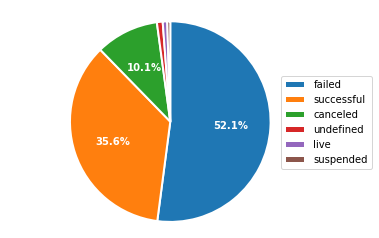

→成功と失敗以外のデータが1割程度あり、これらは不要と考えて除外する。

▼ stateが成功または失敗のデータを抽出


,state
failed,52072
successful,35638



▼ 成功率の平均値
baseline= 0.4063162695245696


In [4]:
# ------------------------------------------------
# 2-2.目的変数（state）の前処理
# ------------------------------------------------
print('\n▼ 目的変数 stateの種類（%）')
per_state = round(df['state'].value_counts() / len(df['state']) * 100,2)
values = list(per_state.values)

# 円グラフ
plt.figure(figsize=(4,4))
plt.pie(values, labels=list(per_state.index),
        wedgeprops={'linewidth': 2,'edgecolor':'white'},
        textprops={'color': 'white', 'weight': 'bold'},
        counterclock=False,startangle=90,
        autopct=lambda p: '{:.1f}%'.format(p) if p >= 2.5 else '')
lgnd=plt.legend(bbox_to_anchor=(1.0, 0.25, 1.55, 0.5), loc="center left", borderaxespad=0.)
plt.axis('equal')
plt.show()
print('→成功と失敗以外のデータが1割程度あり、これらは不要と考えて除外する。')

# stateが成功または失敗のデータを抽出
df = df.query('state in ["successful", "failed"]')

print('\n▼ stateが成功または失敗のデータを抽出')
display(pd.DataFrame(df['state'].value_counts(),columns=['state']))

# 変換（成功=1，失敗=0）
df['state'] = df['state'].map({'failed': 0,'successful': 1})

# 成功率の平均
print('\n▼ 成功率の平均値')
baseline = df['state'].mean()
print('baseline=',baseline)


### 2-3.説明変数の確認


▼ periodの分布 ※歪度： 1.2475560271425914


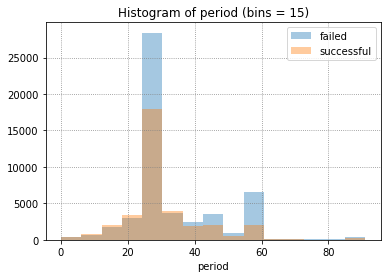

→失敗よりも成功が多い期間がある。

▼ period別の成功数と失敗数


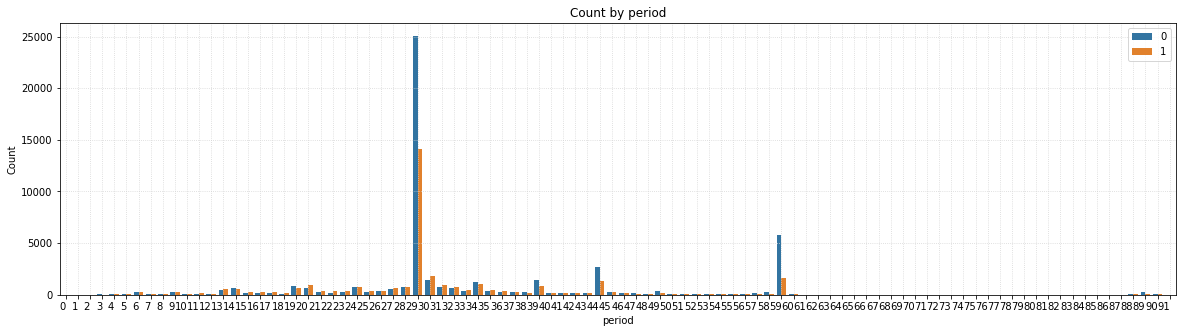

→連続している期間(日数)でも、結構凸凹しているので、ダミー変換することを考える。

▼ period別の成功率 ※赤線：学習データの平均成功率


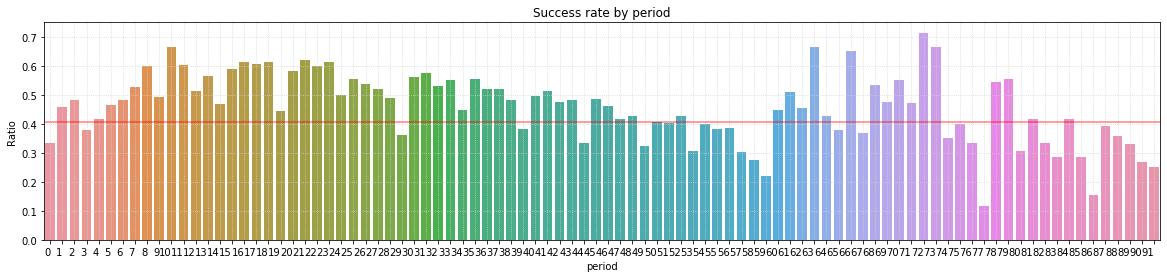

→成功率の平均値（赤線）に対して大きく差がでている為、期間(日数)が説明変数に何らかの影響を与えていると考えられる。


In [5]:
# ------------------------------------------------
# 2-3-1.期間（日数）
# ------------------------------------------------
show_histogram('period',6,4,15)
print('→失敗よりも成功が多い期間がある。')

# 期間(日数)の分布を確認
show_state_count_plot('period',20,5)
print('→連続している期間(日数)でも、結構凸凹しているので、ダミー変換することを考える。')

# 期間(日数)別の成功率を確認
show_successrate_barplot("period",20,4,baseline,False)
print('→成功率の平均値（赤線）に対して大きく差がでている為、期間(日数)が説明変数に何らかの影響を与えていると考えられる。')


▼ usd_goal_realの散布図


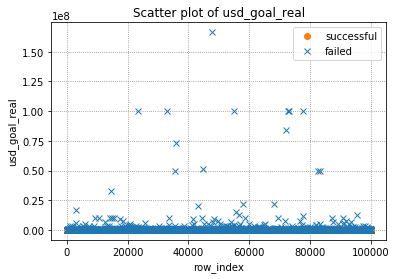

→目標金額が高すぎるものは、失敗している。

▼ usd_goal_realの分布 ※歪度： 90.3107655257426


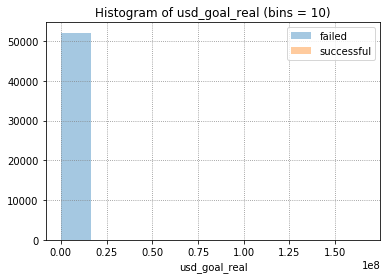

→左に偏っており、目標金額の歪度が大きい為、対数変換して分布を修正する

▼ 対数変換したusd_goal_realの分布


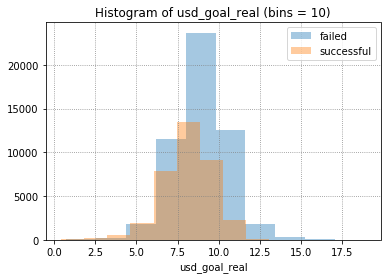

→全体的に目標金額が高くなると失敗しやすくなりそう。


In [6]:
# ------------------------------------------------
# 2-3-2.目標金額
# ------------------------------------------------
# 外れ値がないか散布図で確認
show_scatter_plot('usd_goal_real',6,4)
print('→目標金額が高すぎるものは、失敗している。')
# 目標金額の分布
show_histogram('usd_goal_real',6,4,10)
print('→左に偏っており、目標金額の歪度が大きい為、対数変換して分布を修正する')
show_histogram_log1p('usd_goal_real',6,4,10)
print('→全体的に目標金額が高くなると失敗しやすくなりそう。')


▼ launched_month別の成功数と失敗数


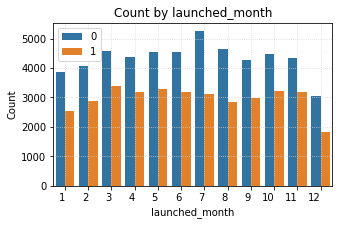


▼ launched_month別の成功率 ※赤線：学習データの平均成功率


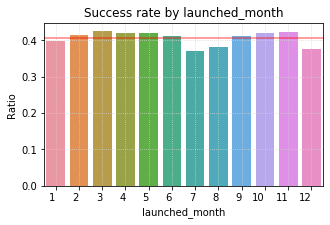

→春と秋あたりに開始すると成功率が若干高まる。

▼ launched_day別の成功数と失敗数


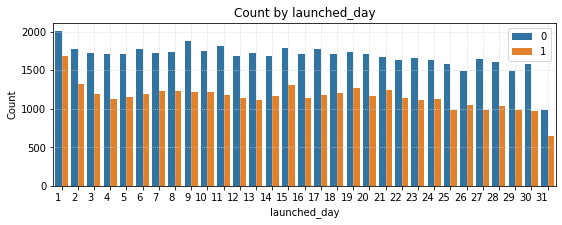


▼ launched_day別の成功率 ※赤線：学習データの平均成功率


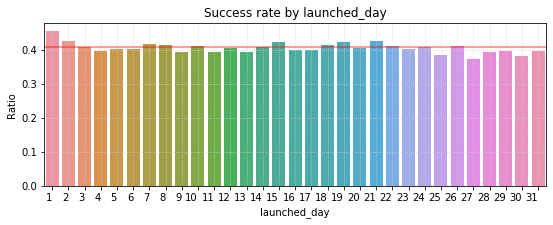

→月の上旬（特に1日開始）の成功率が若干高い。

▼ launched_hour別の成功数と失敗数


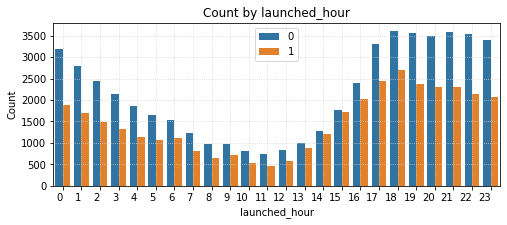


▼ launched_hour別の成功率 ※赤線：学習データの平均成功率


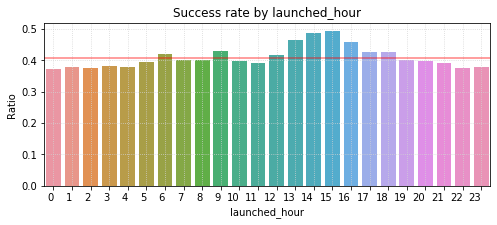

→午後2,3時あたりに開始すると成功率が高まるようだ。


In [7]:
# ------------------------------------------------
# 2-3-3.開始時期（月、日、時間）
# ------------------------------------------------
show_state_count_plot('launched_month',5,3)
show_successrate_barplot('launched_month',5,3,baseline)
print('→春と秋あたりに開始すると成功率が若干高まる。')

show_state_count_plot('launched_day',9,3)
show_successrate_barplot("launched_day",9,3,baseline)
print('→月の上旬（特に1日開始）の成功率が若干高い。')

show_state_count_plot('launched_hour',8,3)
show_successrate_barplot("launched_hour",8,3,baseline)
print('→午後2,3時あたりに開始すると成功率が高まるようだ。')


▼ main_categoryとcategory別のカウントと成功率


state          
                                count      mean
main_category category                         
Art           Art                1917  0.452269
              Ceramics             81  0.481481
              Conceptual Art      235  0.408511
              Digital Art         292  0.297945
              Illustration        784  0.566327
              Installations       111  0.477477
              Mixed Media         637  0.378336
              Painting            822  0.369830
              Performance Art     512  0.476562
              Public Art          775  0.554839
              Sculpture           429  0.396270
              Textiles             71  0.295775
              Video Art            52  0.326923
Comics        Anthologies         103  0.728155
              Comic Books         685  0.667153
...                               ...       ...
Technology    Robots              111  0.504505
              Software            690  0.147826
              Sound               153  0.464052
              Space Exploration    75  0.386667
              Technology         1493  0.245144
              Wearables           240  0.433333
              Web                 851  0.090482
Theater       Comedy               25  0.720000
              Experimental         87  0.609195
              Festivals           145  0.600000
              Immersive            81  0.555556
              Musical             215  0.567442
              Plays               332  0.650602
              Spaces               54  0.462963
              Theater            1751  0.656196

[170 rows x 2 columns]

→main_categoryとcategoryは別々で考慮したほうが良さそう。

▼ main_category別の成功数と失敗数（降順）


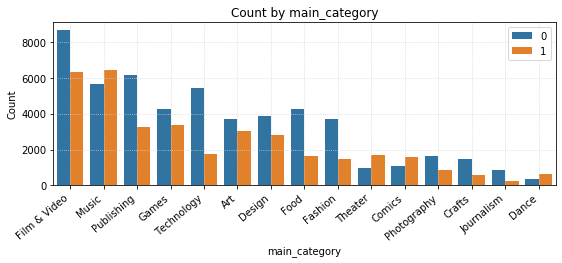


▼ main_category別の成功率（降順）※赤線：学習データの平均成功率


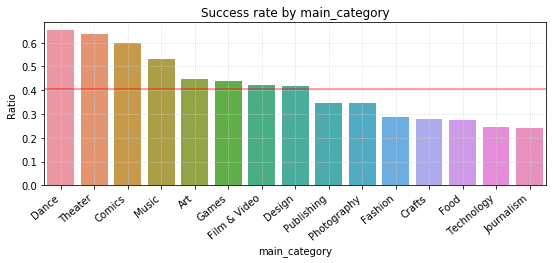

→成功しやすいmain_categoryと失敗しやすいmain_categoryがありそう。

▼ category別の成功数と失敗数（降順）


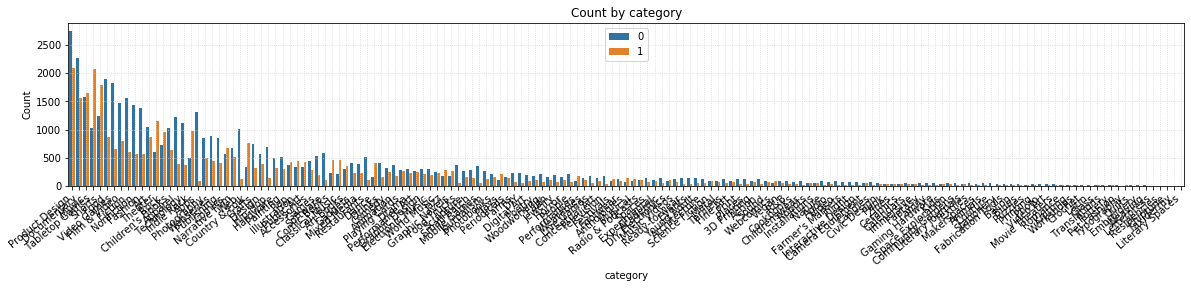

▼ category件数順（Top10）


,category
Product Design,4845
Documentary,3833
Music,3225
Tabletop Games,3098
Shorts,3041
Food,2776
Video Games,2495
Film & Video,2269
Fiction,2177
Nonfiction,1995



▼ category別の成功率（降順）※赤線：学習データの平均成功率


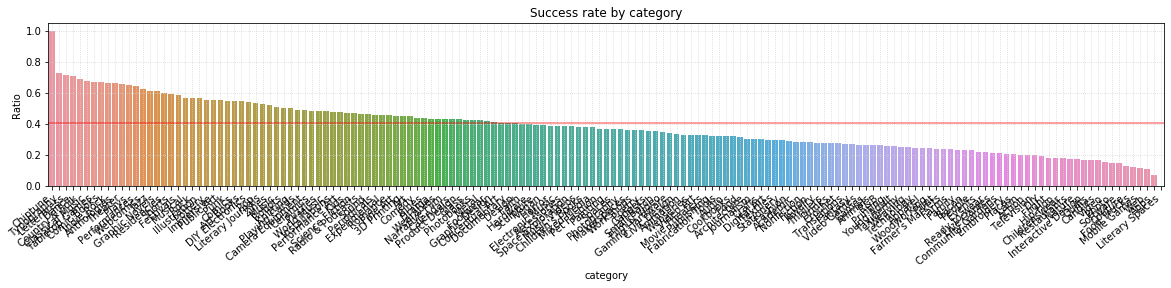

▼ category成功率順（Top10）


,state
category,
Chiptune,1.000000
Typography,0.730769
Letterpress,0.714286
Dance,0.709122
Country & Folk,0.690712
Classical Music,0.675953
Tabletop Games,0.670110
Comic Books,0.667153
Indie Rock,0.664174


→成功しやすいcategoryと失敗しやすいcategoryがありそう。


In [8]:
# ------------------------------------------------
# 2-3-4.主なカテゴリとカテゴリ
# ------------------------------------------------
# main_categoryとcategoryの関係
print('\n▼ main_categoryとcategory別のカウントと成功率')
df_category = df[['main_category','category','state']]

display(df_category.groupby(['main_category', 'category']).agg(['count','mean']))
print('→main_categoryとcategoryは別々で考慮したほうが良さそう。')

# main_category
show_state_count_plot('main_category',9,3, True,40)
show_successrate_barplot('main_category',9,3, baseline,True,40)
print('→成功しやすいmain_categoryと失敗しやすいmain_categoryがありそう。')

# category
show_state_count_plot('category',20,3, True,40)

print('▼ category件数順（Top10）')
display(pd.DataFrame(df['category'].value_counts(),columns=['category']).head(10))

show_successrate_barplot('category',20,3, baseline,True,40)

print('▼ category成功率順（Top10）')
successrate = pd.DataFrame(df['state'].groupby(df['category']).mean())
successrate_s = successrate.sort_values('state', ascending=False) # 成功率降順
display(successrate_s.head(10))

print('→成功しやすいcategoryと失敗しやすいcategoryがありそう。')



▼ currencyとcountry別のカウントと成功率


state          
                  count      mean
currency country                 
AUD      AU        1743  0.301205
CAD      CA        3265  0.334763
         N,0"         3  0.666667
CHF      CH         176  0.267045
DKK      DK         230  0.347826
         N,0"         1  1.000000
EUR      AT         141  0.191489
         BE         154  0.311688
         DE         908  0.284141
         ES         526  0.264259
         FR         670  0.353731
         IE         177  0.333333
         IT         664  0.180723
         LU          19  0.368421
         N,0"         5  0.000000
         NL         611  0.278232
GBP      GB        7760  0.407603
         N,0"         7  0.428571
HKD      HK         132  0.477273
JPY      JP           5  0.400000
MXN      MX         381  0.257218
NOK      N,0"         1  0.000000
         NO         167  0.311377
NZD      NZ         315  0.330159
SEK      N,0"         1  0.000000
         SE         408  0.296569
SGD      SG         119  0.394958
USD      N,0"        38  0.526316
         US       69083  0.421985

→country=N,0"について、除外するかcurrencyから想定できるcountryにするかどうか検討する。

▼ currency別の成功数と失敗数（降順）


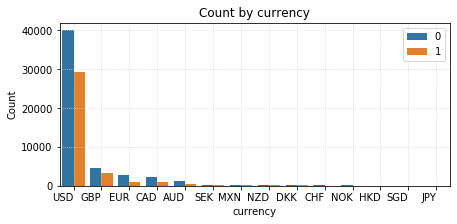


▼ currency別の成功率（降順）※赤線：学習データの平均成功率


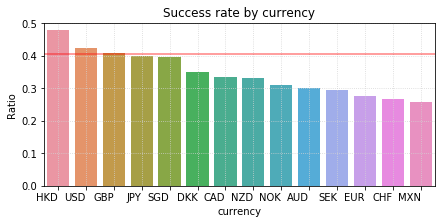


▼ country別の成功数と失敗数（降順）


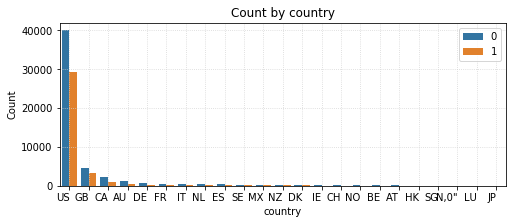


▼ country別の成功率（降順）※赤線：学習データの平均成功率


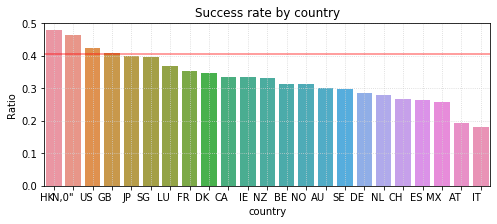

→currencyとcountryは関連しているので、どちらか一方でよいかも。


In [9]:
# ------------------------------------------------
# 2-3-5.currencyとcountry
# ------------------------------------------------
# currencyとcountryの関係を確認
print('\n▼ currencyとcountry別のカウントと成功率')

df_currency = df[['currency','country','state']]
display(df_currency.groupby(['currency','country']).agg(['count','mean']))

print('→country=N,0\"について、除外するかcurrencyから想定できるcountryにするかどうか検討する。')
#print(df["country"].where(df['country'] == 'N,0"').value_counts())
#df = df[(df['country'] != 'N,0"')]

# currency
show_state_count_plot('currency',7,3,True)
show_successrate_barplot('currency',7,3,baseline,True)

# country
show_state_count_plot('country',8,3,True)
show_successrate_barplot('country',8,3,baseline,True)

print('→currencyとcountryは関連しているので、どちらか一方でよいかも。')



▼ name_char_lengthの分布 ※歪度： 0.12592615310790417


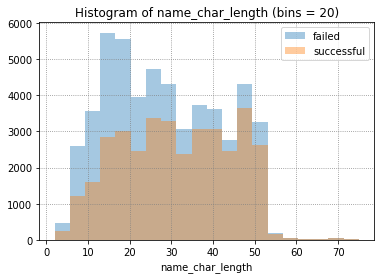

→文字数が少ないと失敗しやすいように見える。

▼ name_char_length別の成功数と失敗数


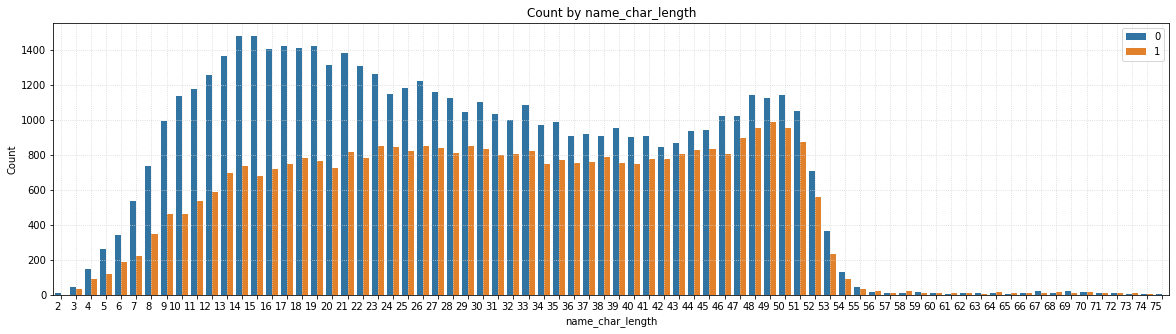


▼ name_char_length別の成功率 ※赤線：学習データの平均成功率


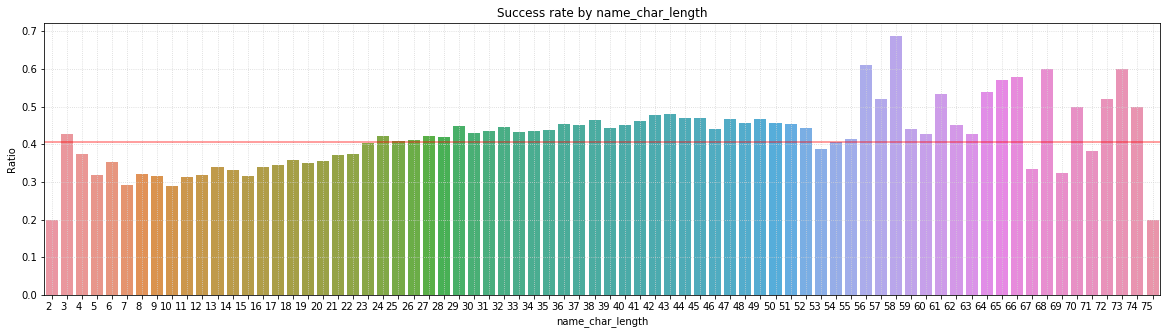

→若干は、成功しやすさの要因になると考えられる。

▼ name_word_numの分布 ※歪度： 0.3419276752157702


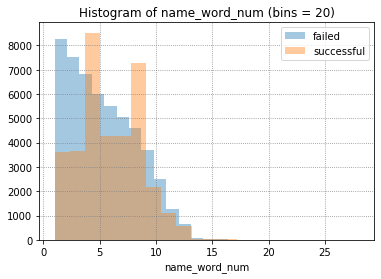


▼ name_word_num別の成功数と失敗数


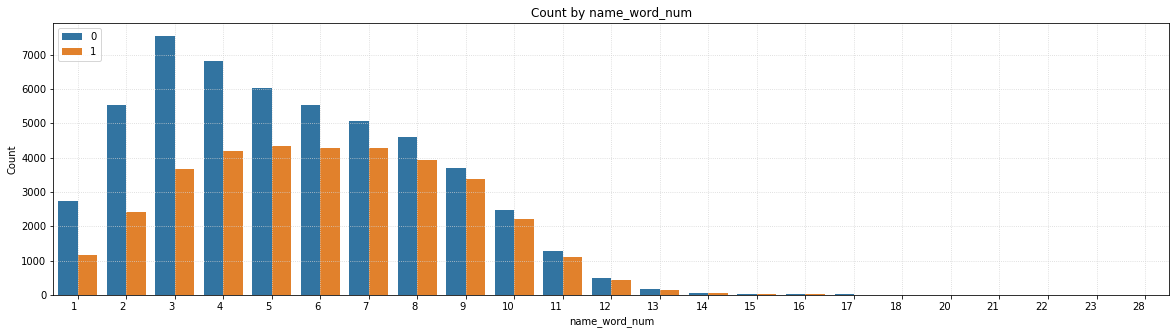


▼ name_word_num別の成功率 ※赤線：学習データの平均成功率


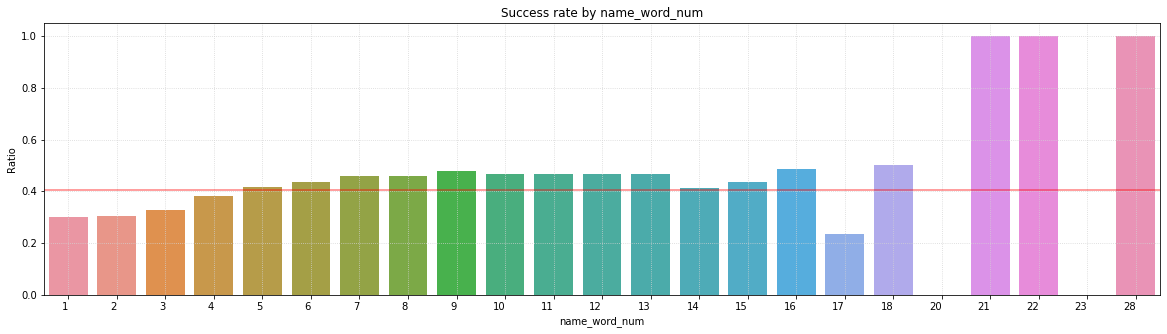

In [10]:
# ------------------------------------------------
# 2-3-6.name_char_length と name_word_num
# ------------------------------------------------
show_histogram('name_char_length',6,4,20)
print('→文字数が少ないと失敗しやすいように見える。')
show_state_count_plot('name_char_length',20,5)
show_successrate_barplot('name_char_length',20,5,baseline)
print('→若干は、成功しやすさの要因になると考えられる。')

show_histogram('name_word_num',6,4,20)
show_state_count_plot('name_word_num',20,5)
show_successrate_barplot('name_word_num',20,5,baseline)


### 2-4.ヒートマップ表示


▼ stateと説明変数（数値項目）の相関関係を確認


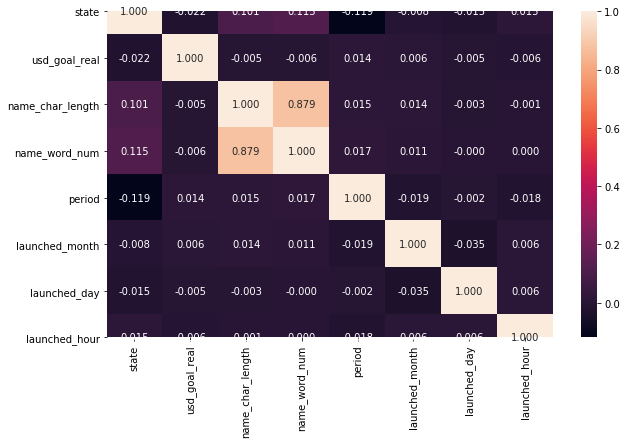

→stateとname_char_lengthの相関関係が他より高いことが分かる。

▼ name_word_num と name_char_length の相関関係 相関係数: 0.879


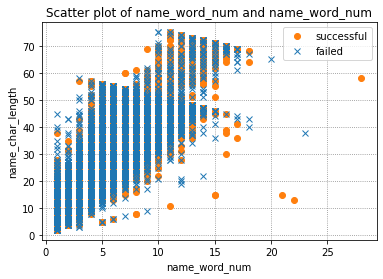

→無相関化してみる

▼ cov_name_word_num と cov_name_char_length の相関関係 相関係数: 0.000


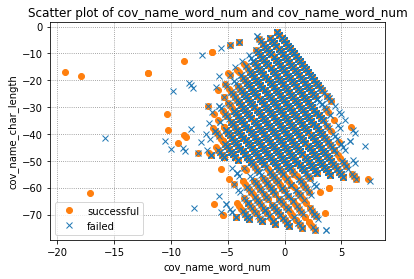

In [11]:
# ------------------------------------------------
# 2-4.stateとの相関係数を確認
# ------------------------------------------------
print('\n▼ stateと説明変数（数値項目）の相関関係を確認')
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, fmt='1.3f')
plt.show()
print('→stateとname_char_lengthの相関関係が他より高いことが分かる。')

# 相関関係の散布図
show_corr_scatter_plot('name_word_num','name_char_length',6,4)

print('→無相関化してみる')
cov_data = df[['name_word_num','name_char_length']].values
cov = np.cov(cov_data, rowvar=0)            # 分散・共分散を求める
_, S = np.linalg.eig(cov)                   # 分散共分散行列の固有ベクトルを用いて
cov_data_decorr = np.dot(S.T, cov_data.T).T #データを無相関化

df['cov_name_word_num'] = cov_data_decorr[:,0]
df['cov_name_char_length'] = cov_data_decorr[:,1]

# 無相関後の散布図
show_corr_scatter_plot('cov_name_word_num','cov_name_char_length',6,4)

### 2-5.説明変数の選定

In [12]:
# ------------------------------------------------
# 2-5.説明変数の選定
# ------------------------------------------------
# データ件須減らして調査
if clf_num2 > 0:
    df = df[0:clf_num2]

tmp_df = df

print('\n▼ 先頭5行表示')
display(tmp_df.head(5))

# 標準化する数値項目(白色化含む)
enc_norm_col = ['usd_goal_real','cov_name_word_num','cov_name_char_length']
tmp_df = tmp_df.drop('name_word_num',axis=1)
tmp_df = tmp_df.drop('name_char_length',axis=1)

# ダミー変換するカテゴリ項目（除外flg、one-hot-encoding変換flg)
enc_dic = {'main_category':[0,1],
           'category':[0,1],
           'country':[0,1],
           'currency':[0,1],
           'launched_month':[0,1],
           'launched_day':[0,1],
           'launched_hour':[0,1],
           'period':[0,1]}

# カテゴリ項目列のリスト生成
tmp_df = df
list_one_hot_cols = []
for k, v in enc_dic.items():
    if(v[0]==1): # drop
        tmp_df = tmp_df.drop(k,axis=1)
        print(k + ' is dropped. ')
    else:
        if(v[1]==1): # one-hot-encoding
            list_one_hot_cols.append(k)

print('\n▼ 行列')
print('tmp_df=',tmp_df.shape)

print('\n▼ 先頭5行表示')
display(tmp_df.head(5))


▼ 先頭5行表示


,category,main_category,currency,state,country,usd_goal_real,name_char_length,name_word_num,period,launched_month,launched_day,launched_hour,cov_name_word_num,cov_name_char_length
0,Poetry,Publishing,GBP,0,GB,1533.95,26,6,58,8,11,12,-1.217263,-26.655549
1,Narrative Film,Film & Video,USD,0,US,30000.00,38,8,59,9,2,4,-1.022435,-38.819513
2,Narrative Film,Film & Video,USD,0,US,45000.00,12,3,44,1,12,0,-0.788806,-12.344140
3,Music,Music,USD,0,US,5000.00,43,7,29,3,17,3,0.862074,-43.557512
5,Restaurants,Food,USD,1,US,50000.00,18,3,34,2,26,13,0.292242,-18.245947



▼ 行列
tmp_df= (5000, 14)

▼ 先頭5行表示


,category,main_category,currency,state,country,usd_goal_real,name_char_length,name_word_num,period,launched_month,launched_day,launched_hour,cov_name_word_num,cov_name_char_length
0,Poetry,Publishing,GBP,0,GB,1533.95,26,6,58,8,11,12,-1.217263,-26.655549
1,Narrative Film,Film & Video,USD,0,US,30000.00,38,8,59,9,2,4,-1.022435,-38.819513
2,Narrative Film,Film & Video,USD,0,US,45000.00,12,3,44,1,12,0,-0.788806,-12.344140
3,Music,Music,USD,0,US,5000.00,43,7,29,3,17,3,0.862074,-43.557512
5,Restaurants,Food,USD,1,US,50000.00,18,3,34,2,26,13,0.292242,-18.245947


## 2-6. データ分割（ホールドアウト法）

In [13]:
# ------------------------------------------------
# 2-6.テスト分割  
# ------------------------------------------------
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(tmp_df.drop('state', axis=1), 
                                                                tmp_df['state'],test_size=0.3, random_state=1234)

print('\n▼ データ分割後行列')
print('X_train_df=',X_train_df.shape)
print('y_train_df=',y_train_df.shape)
print('X_test_df=',X_test_df.shape)
print('y_test_df=',y_test_df.shape)


▼ データ分割後行列
X_train_df= (3500, 13)
y_train_df= (3500,)
X_test_df= (1500, 13)
y_test_df= (1500,)


## 2-7.カテゴリ変換
- URL:https://contrib.scikit-learn.org/categorical-encoding/onehot.html

In [14]:
# ------------------------------------------------
# 2-7.カテゴリ変換  
# ------------------------------------------------

# one-hot-encoding
ce_ohe = ce.OneHotEncoder(cols=list_one_hot_cols, use_cat_names=True)
enc_X_train_df = ce_ohe.fit_transform(X_train_df)
enc_X_test_df = ce_ohe.transform(X_test_df)

print('\n▼ カテゴリ変換後行列')
print('enc_X_train_df=',enc_X_train_df.shape)
print('enc_X_test_df=',enc_X_test_df.shape)

print('\n▼ カテゴリ変換後')
display(enc_X_train_df.head(5))


▼ カテゴリ変換後行列
enc_X_train_df= (3500, 346)
enc_X_test_df= (1500, 346)

▼ カテゴリ変換後


,category_Fashion,category_Country & Folk,category_Technology,category_Festivals,category_3D Printing,category_Product Design,category_Video Games,category_Indie Rock,category_Theater,category_Illustration,category_Anthologies,category_Gaming Hardware,category_Photography,category_Jewelry,category_Documentary,category_Comics,category_Jazz,category_Pop,category_Gadgets,category_Animation,category_Classical Music,category_Crafts,category_Music,category_Design,category_Children's Books,category_Accessories,category_Publishing,category_Tabletop Games,category_Graphic Design,category_Farms,category_Video,category_Art,category_Food,category_Comedy,category_Hip-Hop,category_Drama,category_Woodworking,category_Performances,category_Fiction,category_Plays,category_Film & Video,category_Photobooks,category_Art Books,category_Software,category_Shorts,category_Architecture,category_Playing Cards,category_Fabrication Tools,category_Drinks,category_Food Trucks,category_Apps,category_Painting,category_Radio & Podcasts,category_Literary Journals,category_Romance,category_DIY Electronics,category_Metal,category_Thrillers,category_World Music,category_Rock,category_Web,category_Weaving,category_Vegan,category_Poetry,category_Mixed Media,category_Young Adult,category_Apparel,category_Webseries,category_Restaurants,category_Television,category_Wearables,category_Public Art,category_R&B,category_Makerspaces,category_Narrative Film,category_Dance,category_Journalism,category_People,category_Science Fiction,category_Conceptual Art,category_Candles,category_Comic Books,category_Games,category_Nature,category_Footwear,category_Horror,category_Blues,category_Small Batch,category_Periodicals,category_Hardware,category_Webcomics,category_Experimental,category_Nonfiction,category_Digital Art,category_Places,category_Sculpture,category_Flight,category_Robots,category_Puzzles,category_Music Videos,category_Action,category_Faith,category_Electronic Music,category_Performance Art,category_Cookbooks,category_Letterpress,category_Print,category_Installations,category_Graphic Novels,category_Interactive Design,category_Academic,category_Movie Theaters,category_Photo,category_Fine Art,category_Typography,category_Live Games,category_Calendars,category_DIY,category_Events,category_Immersive,category_Pet Fashion,category_Bacon,category_Mobile Games,category_Sound,category_Knitting,category_Workshops,category_Family,category_Printing,category_Ceramics,category_Space Exploration,category_Ready-to-wear,category_Fantasy,category_Musical,category_Audio,category_Camera Equipment,category_Spaces,category_Civic Design,category_Zines,category_Community Gardens,category_Video Art,category_Animals,category_Childrenswear,category_Textiles,category_Latin,category_Translations,category_Crochet,category_Kids,category_Stationery,category_Pottery,category_Farmer's Markets,category_Punk,main_category_Fashion,main_category_Music,main_category_Technology,main_category_Film & Video,main_category_Design,main_category_Games,main_category_Theater,main_category_Art,main_category_Publishing,main_category_Photography,main_category_Comics,main_category_Crafts,main_category_Food,main_category_Journalism,main_category_Dance,currency_USD,currency_AUD,currency_GBP,currency_EUR,currency_CAD,currency_NOK,currency_NZD,currency_CHF,currency_DKK,currency_SEK,currency_MXN,currency_HKD,currency_SGD,country_US,country_AU,country_GB,country_NL,country_FR,country_ES,country_CA,country_NO,country_NZ,country_BE,country_IE,country_CH,country_DE,country_DK,country_AT,country_SE,country_IT,country_MX,country_HK,"country_N,0""",country_SG,usd_goal_real,name_char_length,name_word_num,period_29.0,period_30.0,period_59.0,period_6.0,period_37.0,period_36.0,period_5.0,period_63.0,period_13.0,period_39.0,period_0.0,period_57.0,period_34.0,period_28.0,period_35.0,period_9.0,period_20.0,period_31.0,period_55.0,period_7.0,period_18.0,period_11.0,period_23.0,period_24.0,period_25.0,period_44.0,period_14.0,period_27.0,peri

## 2-8. 標準化
- https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

In [15]:
# ------------------------------------------------
# 2-7.標準化
# ------------------------------------------------
# 標準化する列名と列番号の辞書
dic_norm_col = {}
for col_name in enc_norm_col:
    dic_norm_col.setdefault(col_name, enc_X_train_df.columns.get_loc(col_name))
X_columns = enc_X_train_df.columns
    
# ndarrayに変換
X_train = enc_X_train_df.values
y_train = y_train_df.values
X_test = enc_X_test_df.values
y_test = y_test_df.values

print('\n▼ndarrayに変換後')
print('X_train.shape=',X_train.shape)
#print('X_train[:1,:]=\n',X_train[:1,:])

print('\n▼標準化対象列=',dic_norm_col)
for col_name,col_idx in dic_norm_col.items():
    stdsc = StandardScaler()
    X_train[:,col_idx:col_idx+1] = stdsc.fit_transform(X_train[:,col_idx:col_idx+1])
    X_test[:,col_idx:col_idx+1] = stdsc.transform(X_test[:,col_idx:col_idx+1])
    
print('\n▼標準化後')
print('X_train.shape=',X_train.shape)
#print('X_train[:1,:]=\n',X_train[:1,:])


▼ndarrayに変換後
X_train.shape= (3500, 346)

▼標準化対象列= {'usd_goal_real': 200, 'cov_name_word_num': 344, 'cov_name_char_length': 345}

▼標準化後
X_train.shape= (3500, 346)


## 3.モデル構築

## 3-1. パラメーターチューニング
### 3-1-1. ロジスティック回帰
- URL:https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html

In [16]:
lr_clf = SGDClassifier(loss='log',max_iter=10000,fit_intercept=True,random_state=1234,tol=1e-3)
lr_param_grid = {'penalty' : ['none','l1','l2','elasticnet'], #正則化項
                 'alpha' : [0.0001] # 正則化項の効き具合(デフォルト= 0.0001)
                }
best_lr = algo_grid_search(lr_clf, lr_param_grid, X_train, y_train)
print('BestModel:',best_lr)

BestScore: 0.628000 using {'alpha': 0.0001, 'penalty': 'none'}
------------------------------------------------------
BestModel: SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=10000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='none',
       power_t=0.5, random_state=1234, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)


### 3-1-2. サポートベクターマシン
- URL:https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC

In [17]:
svc_clf = SVC()
svc_param_grid = [{'kernel': ['linear'], 'C': [0.1,1,10,100]}]
best_SVC1 = algo_grid_search(svc_clf, svc_param_grid, X_train, y_train)
print('BestModel:',best_SVC1)

BestScore: 0.664857 using {'C': 0.1, 'kernel': 'linear'}
------------------------------------------------------
BestModel: SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)


In [18]:
#svc_clf = SVC()
#svc_param_grid = [#{'kernel': ['linear'], 'C': [0.1,1,10,100]},
#                  {'kernel': ['rbf'], 'gamma': [10 ,1, 0.1, 1e-2, 1e-3],'C': [0.1,1,10],'random_state' : [1234]}]
#best_SVC2 = algo_grid_search(svc_clf, svc_param_grid, X_train, y_train)
#print('BestModel:',best_SVC2)

IndentationError: unexpected indent (<ipython-input-18-39c61b02c858>, line 3)

## 3-2. 学習曲線
- URL:https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html

KFold(n_splits=5, random_state=1234, shuffle=False)


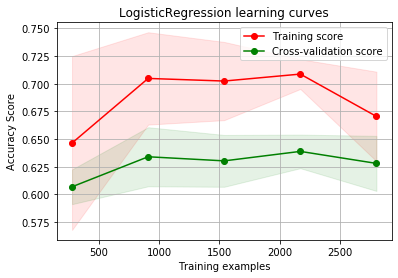

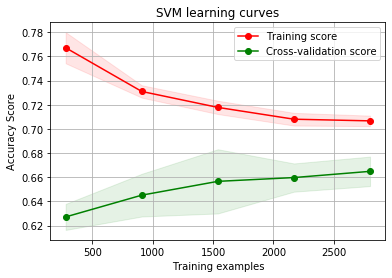

In [19]:
kfold = KFold(n_splits=5, random_state=1234)
print(kfold)
# ロジスティック回帰の学習曲線
plot_learning_curve(best_lr,"LogisticRegression learning curves",X_train,y_train,cv=kfold)
# SVC1の学習曲線
plot_learning_curve(best_SVC1,"SVM learning curves",X_train,y_train,cv=kfold)
# SVC2の学習曲線
#plot_learning_curve(best_SVC2,"SVM learning curves",X_train,y_train,cv=kfold)

## 4. モデル検証


▼ 重みを表示（絶対値の降順：Top30）


,feature,weight
0,usd_goal_real,-1.092814
1,category_Tabletop Games,1.084159
2,category_Shorts,0.890281
3,category_Indie Rock,0.837052
4,category_Country & Folk,0.820661
5,period_59.0,-0.714062
6,main_category_Comics,0.668149
7,main_category_Theater,0.650873
8,category_Sculpture,-0.646869
9,period_21.0,0.626983



▼ 重みの大きさを横棒グラフで表示


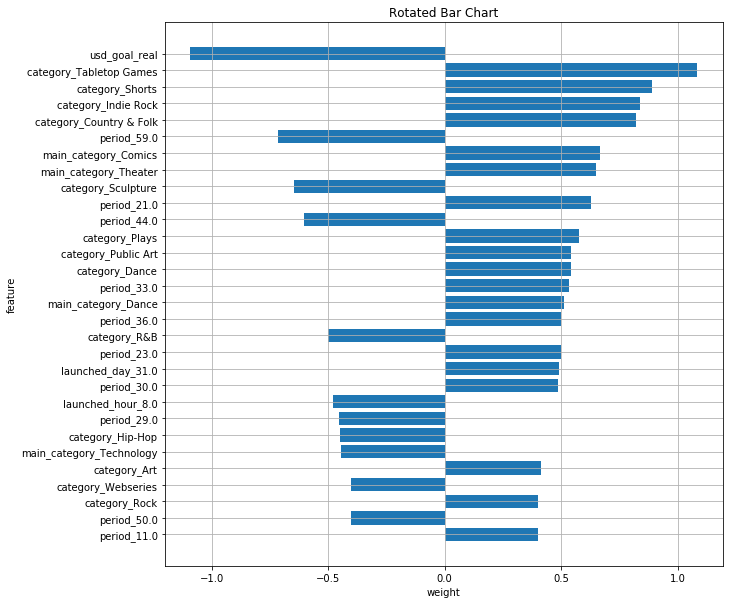

In [20]:
# ****************************************************************************
# ◆ 3.モデル構築
# ****************************************************************************
# ------------------------------------------------
# 3-1.モデルを生成して学習する  
# ------------------------------------------------
# 学習
#best_clf = best_lr
best_clf = best_SVC1
#best_clf = best_SVC2

best_clf.fit(X_train, y_train)

# パラメータ確認
#print('-------------------------------------------')
#for key, value in best_clf.__dict__.items():
#    print(key, ':', value)
#    print('-------------------------------------------')


#print('w0 = {:.3f}'.format(clf.intercept_[0]))

# 結果をDataFrameへ格納
res_df = pd.DataFrame(columns=['feature','weight','abs_w'])
res_df['feature'] = list(X_columns)
res_df['weight'] = np.reshape(best_clf.coef_[0], -1).tolist() # 重み
res_df['abs_w'] = abs(res_df['weight']) # 絶対値

# 重みの絶対値の降順ソート
print('\n▼ 重みを表示（絶対値の降順：Top30）')
res_df = res_df.sort_values('abs_w', ascending=False)
res_df.reset_index(drop=True,inplace=True)
res_df = res_df.drop('abs_w', axis=1)
res_df_head = res_df.head(30)
display(res_df_head.head(30))

# 重みの大きさを横棒グラフで表示
print('\n▼ 重みの大きさを横棒グラフで表示')
plt.figure(figsize=(10, 10))
plt.barh(np.arange(len(res_df_head['feature']))[::-1], res_df_head['weight'], align='center')
plt.yticks(np.arange(len(res_df_head['feature']))[::-1], res_df_head['feature'])
plt.title('Rotated Bar Chart')
plt.xlabel('weight')
plt.ylabel('feature')
plt.grid()
plt.show()


## 4.モデル評価

In [21]:
# ****************************************************************************
# ◆ 4.モデル評価
# ****************************************************************************
# ------------------------------------------------
# 4-1.モデル検証  
# ------------------------------------------------
y_train_pred = best_clf.predict(X_train) # 訓練データ
y_test_pred = best_clf.predict(X_test) # テストデータ

#print('\n▼ モデルの予測結果(先頭10件)')
#print(y_test_pred[:11])

# 予測確率を出力
#print('\n▼ 結果の予測確率(先頭10件)\n(失敗する確率：成功する確率):')
#print(best_clf.predict_proba(X)[:11].astype(float))

# ------------------------------------------------
# 4-2.モデル評価結果
# ------------------------------------------------
print('\n▼ モデルの評価結果')

# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y_test, y_test_pred)))

# 正答率を表示
print('正答率（訓練データ） = {:.3f}%'.format(100 * accuracy_score(y_train, y_train_pred)))
print('正答率（テストデータ）= {:.3f}%'.format(100 * accuracy_score(y_test, y_test_pred)))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_test_pred)

# 成功に関するPrecision, Recall, F1-scoreを表示
print('適合率（Precision※精度) = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall※検出率) = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

# 予測値と正解のクロス集計
print('\n▼ 混同行列')
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_test_pred), 
                        index=['正解 = 資金調達失敗', '正解 = 資金調達成功'], 
                        columns=['予測 = 資金調達失敗', '予測 = 資金調達成功'])
display(conf_mat)

proc_time = time() - start_notebook
print('計算時間（分）：',proc_time/60)


▼ モデルの評価結果
対数尤度 = -11.444
正答率（訓練データ） = 70.514%
正答率（テストデータ）= 66.867%
適合率（Precision※精度) = 67.985%
再現率（Recall※検出率) = 82.139%
F1値（F1-score） = 74.395%

▼ 混同行列


,予測 = 資金調達失敗,予測 = 資金調達成功
正解 = 資金調達失敗,722,157
正解 = 資金調達成功,340,281


計算時間（分）： 28.19952940940857


### Day1 モデルの評価結果
- 対数尤度 = -14.931
- 正答率 = 56.772%
- 適合率（Precision※精度) = 73.061%
- 再現率（Recall※検出率) = 43.540%
- F1値（F1-score） = 54.563%